In [678]:
import json
import tweepy
from datetime import timedelta
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import os
import cv2
import pandas as pd
import gc

In [11]:
f = open('../../twitter_keys2.json','r')
api_keys = json.loads(f.read())
f.close()
twitter_keys = {'consumer_key':api_keys['twitter_keys']['consumer_key'],'consumer_secret':api_keys['twitter_keys']['consumer_secret'],'access_token_key':api_keys['twitter_keys']['access_token_key'],'access_token_secret': api_keys['twitter_keys']['access_token_secret']}

# Use twitter API
auth = tweepy.OAuthHandler(twitter_keys['consumer_key'], twitter_keys['consumer_secret'])
auth.set_access_token(twitter_keys['access_token_key'], twitter_keys['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [67]:
LABELS = open("coco.names").read().strip().split("\n")
path_weights = "yolo_superfast/Yolo-Fastest/COCO/yolo-fastest.weights"
path_config = "yolo_superfast/Yolo-Fastest/COCO/yolo-fastest.cfg"

In [13]:
# Query timeline
def get_statuses(user_id,num_status,rt=False,rply=False):
    return api.user_timeline(user_id=user_id,count=num_status,include_rts=rt, exclude_replies=not rply, tweet_mode='extended', wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [88]:
elon = ['elonmusk', 44196397]
elon_statuses = get_statuses(elon[1],200)

In [119]:
images_stati = list(filter(lambda x : x.entities.get('media') is not None, elon_statuses))

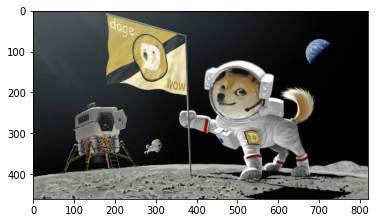

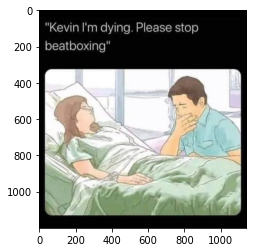

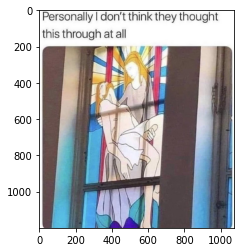

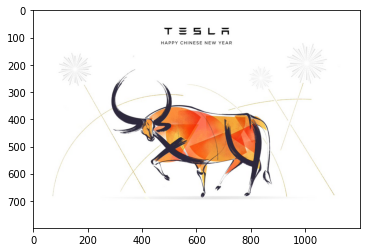

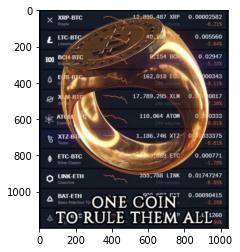

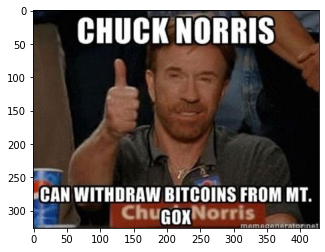

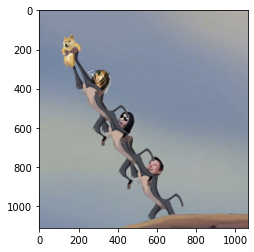

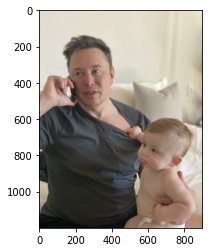

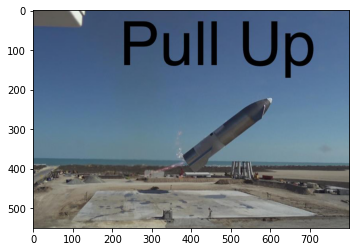

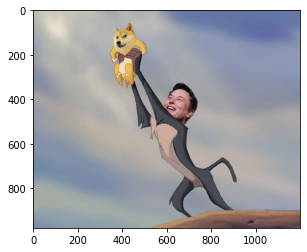

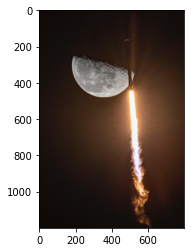

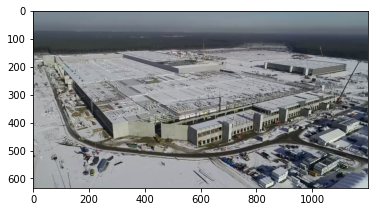

In [94]:
imgs = []
for i in images_stati:
    response = requests.get(i.entities.get('media')[0]['media_url'])
    img = Image.open(BytesIO(response.content))
    imgs.append(np.array(img))
    plt.imshow(img)
    plt.show()

In [68]:
net = cv2.dnn.readNetFromDarknet(path_config, path_weights)

person


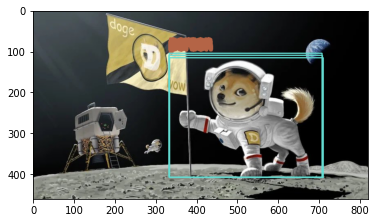

bed


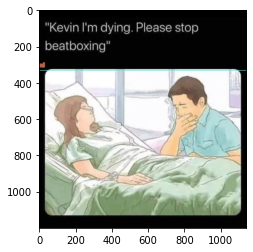

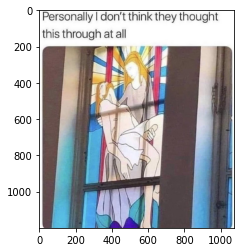

bird


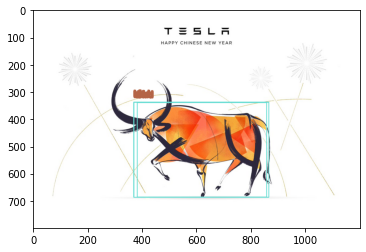

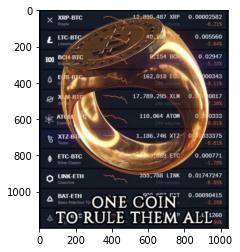

person


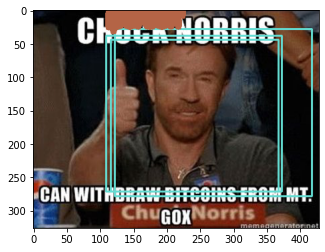

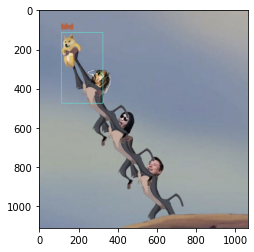

person
person


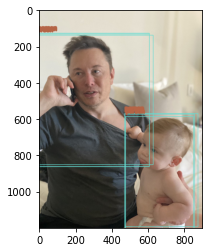

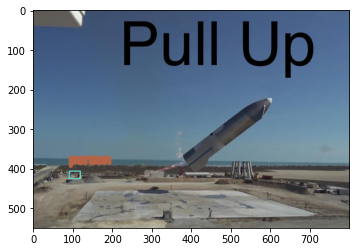

person


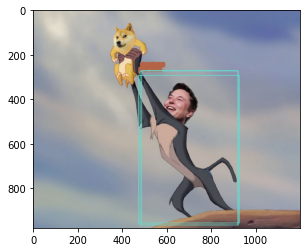

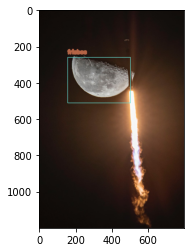

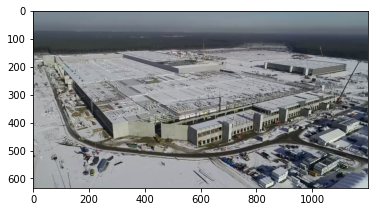

In [124]:
confidence_threshold = 0.2
threshold = 0.1

for img in imgs:
    plt.imshow(yolo_doge(img))
    plt.show()
    

person


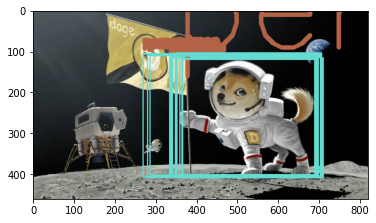

In [123]:
def yolo_doge(img):
    (H, W) = img.shape[:2]
    layerNames = net.getLayerNames()
    layerNames = [layerNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    ##construct a blob from the input image
    blob = cv2.dnn.blobFromImage(img, 1 / 255.0,(416,416),swapRB=True,crop=False)
    net.setInput(blob)
    netOutputs = net.forward(layerNames)

    # Constructing bounding box
    boxes = []
    confidences = []
    classIDs = []

    for output in netOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if(confidence>confidence_threshold):
                box = detection[0:4] * np.array([W, H, W, H])
                (Xcenter, Ycenter, width, height) = box.astype("int")
                #obtain coordinates for top left corner
                tl_x = int(Xcenter - (width/2))
                tl_y = int(Ycenter - (height/2))
                boxes.append([tl_x,tl_y,int(width),int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    #applying non maxima suppression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold,threshold)
    if(len(idxs)>0):
        for i in idxs.flatten():
            (x,y) = (boxes[i][0], boxes[i][1])
            (w,h) = (boxes[i][2], boxes[i][3])
            cv2.rectangle(img, (x,y), (x+w,y+h), (100,220,210), 2)
            text = LABELS[classIDs[i]]
            print(text)
            cv2.putText(img, text, (x,y-20), cv2.FONT_HERSHEY_SIMPLEX,1, (180,100,70), 10)
    return img

confidence_threshold = 0.2
threshold = 0.1


new_im = yolo_doge(np_im)
plt.imshow(new_im)


# Pytorch Simple NN

In [412]:
import torch
import torchvision
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

## Training data and data aug

In [584]:
H = 128
W = 128

In [585]:
print(len(doge_ims))
print(len(non_doge_ims))

331
266


In [586]:
doge_array = np.stack(doge_ims,axis=0)
non_doge_array = np.stack(non_doge_ims,axis=0)

In [612]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self, train_df, transform=None):
        
        # The transform is going to be used on image
        self.transform = transform
        self.train_df = train_df
        
        # Number of images in dataset
        self.len= len(self.train_df)
    
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        # Image file path
        img_name = train_df['impath'][idx]

        # Open image file
        img = Image.open(img_name)
        img = np.array(img.resize((H,W)))     
        if len(img.shape) == 2:
            img2 = np.zeros( ( np.array(img).shape[0], np.array(img).shape[1], 3 ) )
            img2[:,:,0] = img # same value in each channel
            img2[:,:,1] = img
            img2[:,:,2] = img
            img = img2
        
        # The class label for the image
        y = train_df['doge'][idx]
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            img = self.transform(img)

        return img, y

In [628]:
doge_df = pd.DataFrame(list(filter(lambda x : not x.endswith('.DS_Store'),['Doge_images/'+i for i in os.listdir('Doge_images')])),columns =['impath'])
non_doge_df = pd.DataFrame(list(filter(lambda x : not x.endswith('.DS_Store'),['Non_doge_images/'+i for i in os.listdir('Non_doge_images')])),columns =['impath'])
doge_df['doge'] = 1.0
non_doge_df['doge'] = 0.0
train_df = doge_df.append(non_doge_df)
train_df = train_df.sample(frac=1).reset_index()

In [629]:
doge_dataset = Dataset(train_df)

In [630]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        
        return img


class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h,left: left + new_w]

        return image


class ToTensor(object):
    def __call__(self, sample):
        image = sample
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        return image.float()

In [631]:
s = 4.5

In [632]:
torch.tensor(s)

tensor(4.5000)

(128, 128, 3)


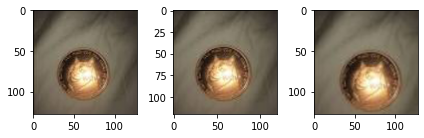

In [633]:
scale = Rescale(128)
crop = RandomCrop(120)
composed = transforms.Compose([Rescale(150), RandomCrop(128)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample, _ = doge_dataset[65]

print(sample.shape)

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(transformed_sample)
    plt.tight_layout()

plt.show()

In [634]:
transformed_dataset = Dataset(train_df, transform = transforms.Compose([Rescale(136), RandomCrop(128),ToTensor()]))

In [657]:
train_size = int(0.8 * len(transformed_dataset))
test_size = len(transformed_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle = True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle = True, num_workers=0)

In [671]:
print('training data length : %d' % len(train_dataset))
print('validation data length : %d' % len(val_dataset))

training data length : 477
validation data length : 120


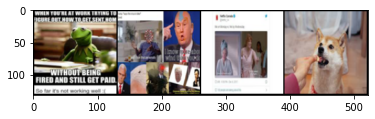

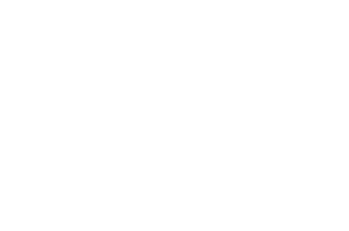

In [658]:
def show_batch(sample_batch):
    batch_size = len(sample_batch)
    im_size = sample_batch.size(2)
    
    grid = utils.make_grid(sample_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    plt.show()
    
for i_batch, (sample_batched, _) in enumerate(train_dataloader):
    
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Training

In [659]:
import torch.optim as optim
from math import floor
import collections

In [660]:
# Function for calculating the output shape after a convolutional or max pooling layer
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0):
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor(((h_w[0]+(2*pad)-(kernel_size[0]-1)-1)/stride)+1)
    w = floor(((h_w[1]+(2*pad)-(kernel_size[1]-1)-1)/stride)+1)
    return h, w

In [661]:
input_dims_res = (128,128)

out1 = conv_output_shape(input_dims_res, kernel_size=4, stride=2, pad=0)
out2 = conv_output_shape(out1, kernel_size=2, stride=2, pad=0) # max pool
out3 = conv_output_shape(out2, kernel_size=3, stride=2, pad=0)
out4 = conv_output_shape(out3, kernel_size=2, stride=2, pad=0) # max pool
params = collections.OrderedDict()

params['conv1'] = {'in_ch':3, 'out_ch':32, 'kernel':4, 'stride':2, 'pad':0}
params['conv2'] = {'in_ch':32, 'out_ch':64, 'kernel':3, 'stride':2, 'pad':0}

params['fc__1'] = {'h_w':out4}
print(out4)

(7, 7)


In [662]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(params['conv1']['in_ch'], params['conv1']['out_ch'], kernel_size=params['conv1']['kernel'], stride=params['conv1']['stride'],padding=params['conv1']['pad'])
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(params['conv2']['in_ch'], params['conv2']['out_ch'], kernel_size=params['conv2']['kernel'], stride=params['conv2']['stride'],padding=params['conv2']['pad'])
        self.fc1 = nn.Linear(params['conv2']['out_ch']*params['fc__1']['h_w'][0]*params['fc__1']['h_w'][1],128)
        self.fc2 = nn.Linear(128,32)
        self.fc3 = nn.Linear(32,1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(x.size(0))
        return x

net = Net()

In [663]:
criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [682]:
def plot_performance(model, train_loader, val_loader, loss_metrics, ylim=()):

    fig = plt.figure(figsize = (10,10))

    plt.plot(loss_metrics['training_loss'],   label = 'training loss')
    plt.plot(loss_metrics['validation_loss'], label = 'validation loss')
    
    plt.show()

In [687]:
def train(model, loss_func, optimizer, train_loader, val_loader, epochs=10, plot=0):
    loss_metrics = {'training_loss':[], 'validation_loss':[]}

    for epoch in range(epochs):
        cost = 0
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            cost += loss.data

        loss_metrics['training_loss'].append(cost/len(train_loader))
        model.eval()
        val_se = 0
        for x_val, y_val in val_loader:
            z = model(x_val)
            val_se += loss_func(z, y_val).data
            
        if epoch%2==0:
            print('Epoch: %d, training loss: %.2f, validation loss: %.2f' %(epoch,cost/len(train_loader),val_se/len(val_loader)))
        loss_metrics['validation_loss'].append(val_se / len(val_loader))
        
        if plot:
            if epoch%plot == 0 and epoch != 0:
                plot_performance(model,train_loader,val_loader,loss_metrics)

    print('Finished Training')

Epoch: 0, training loss: 0.64, validation loss: 0.64


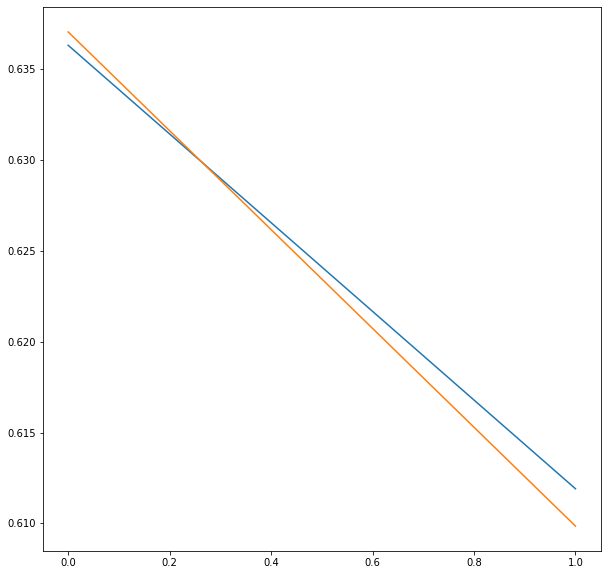

Epoch: 2, training loss: 0.76, validation loss: 0.66


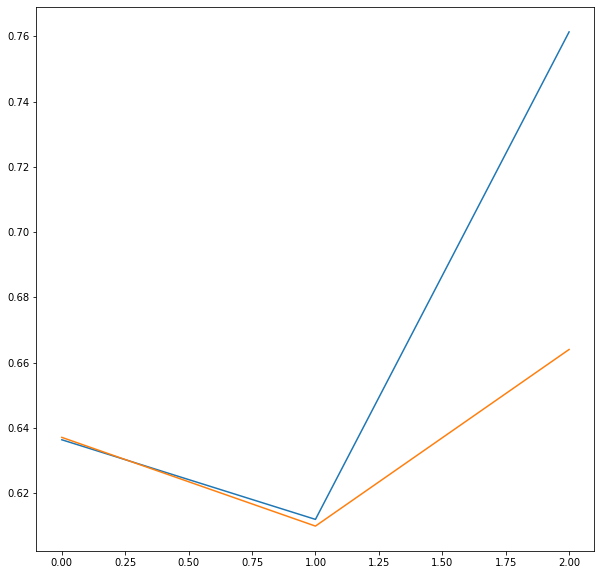

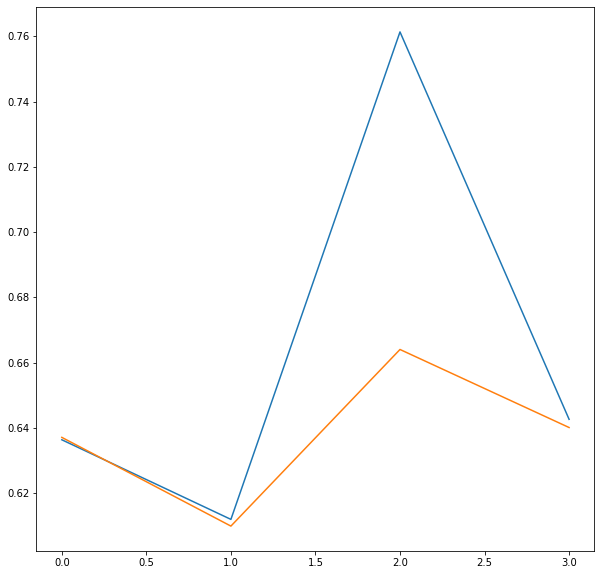

Epoch: 4, training loss: 0.62, validation loss: 0.60


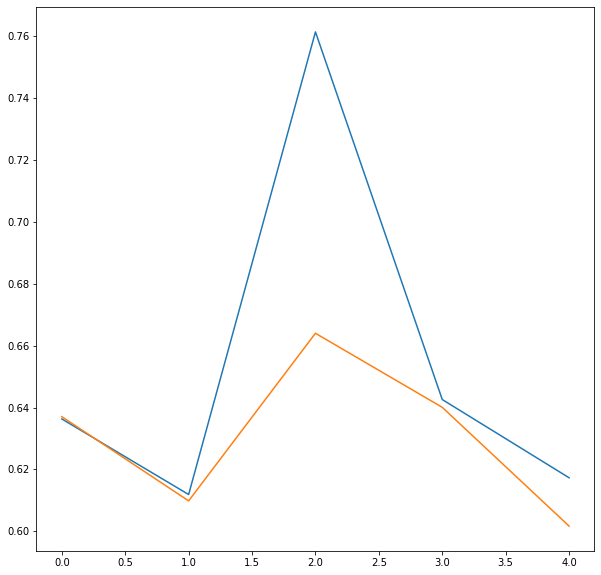

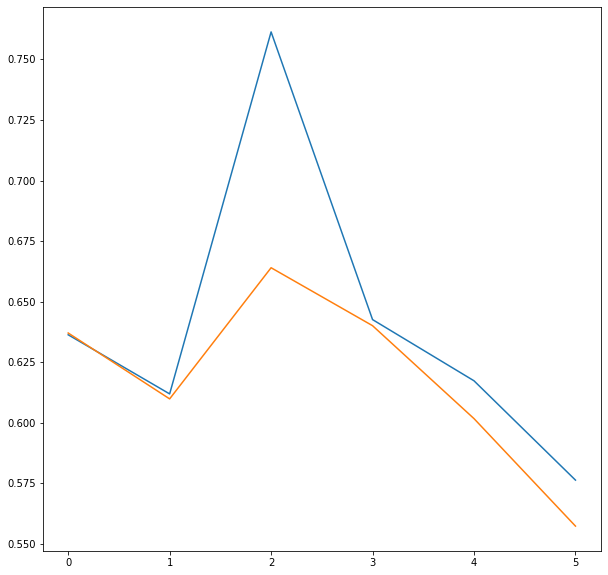

Epoch: 6, training loss: 0.53, validation loss: 0.49


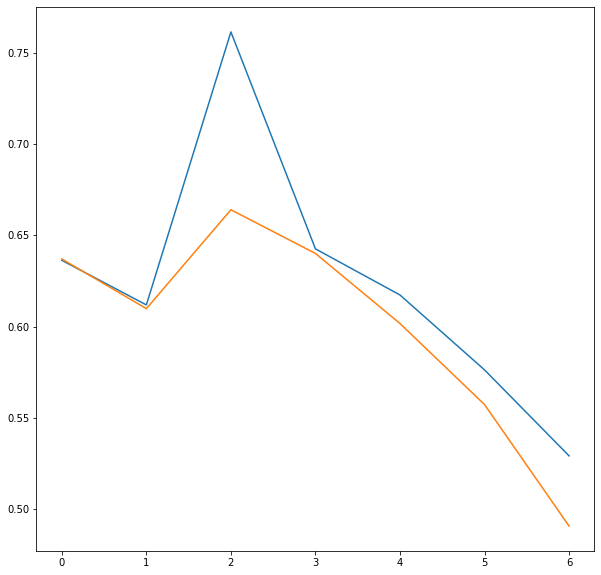

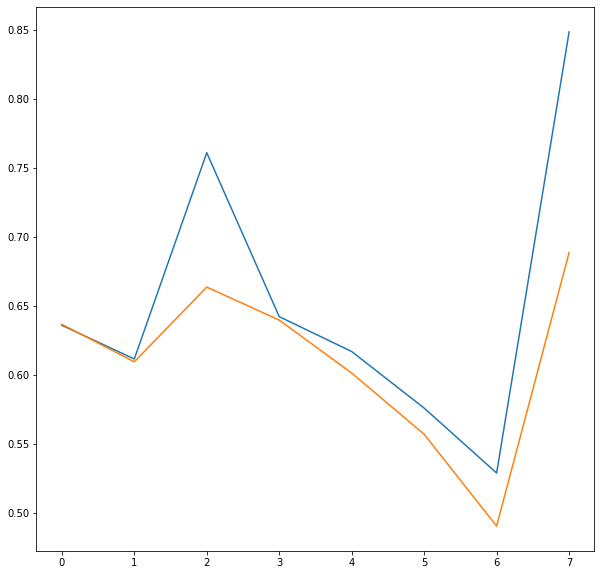

Epoch: 8, training loss: 0.69, validation loss: 0.69


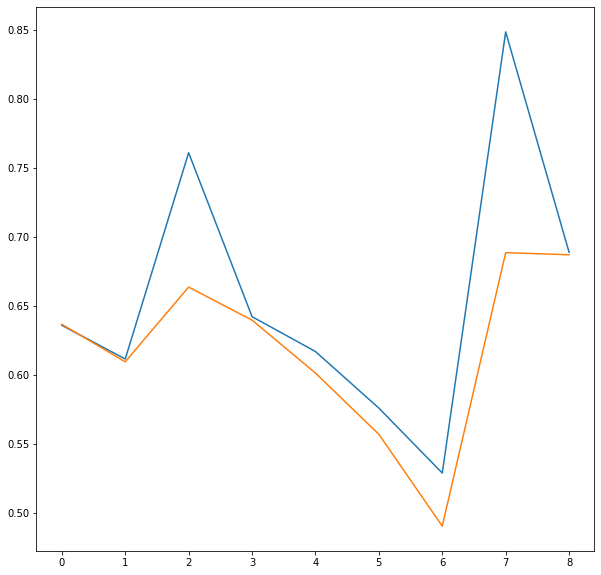

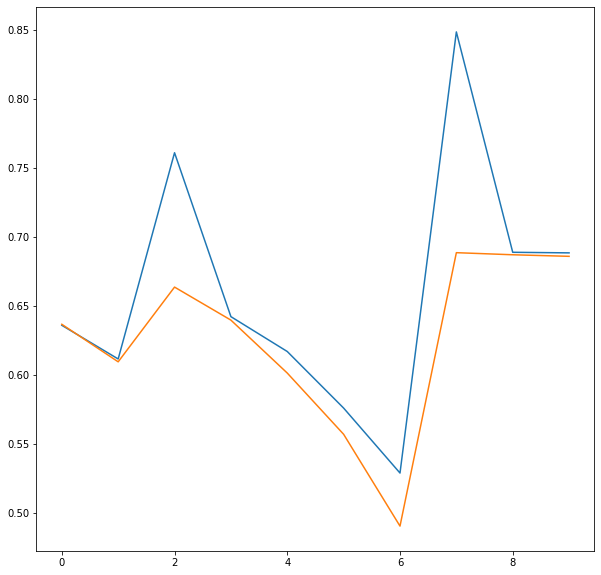

Epoch: 10, training loss: 0.69, validation loss: 0.69


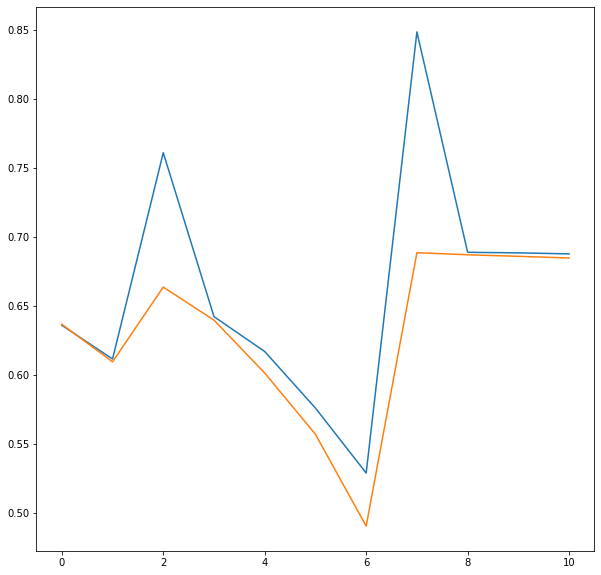

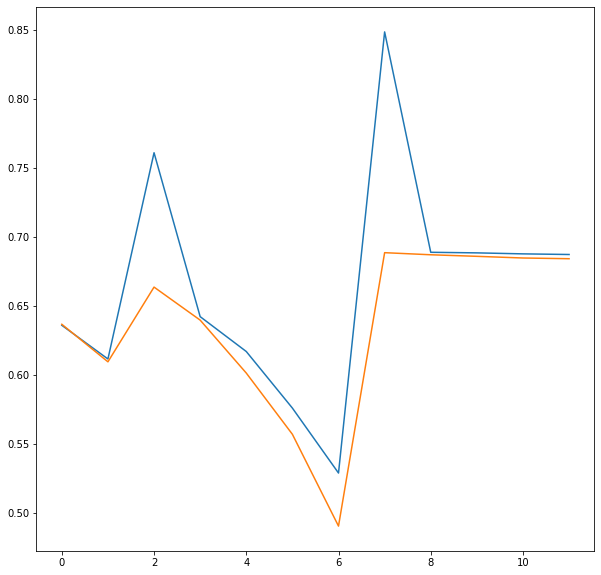

Epoch: 12, training loss: 0.69, validation loss: 0.68


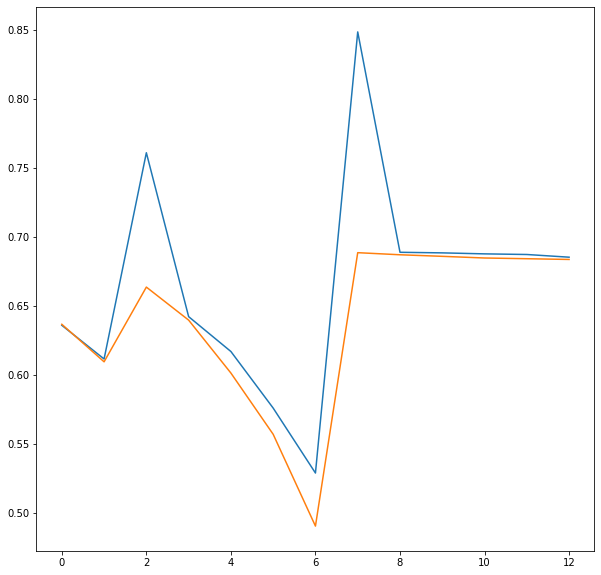

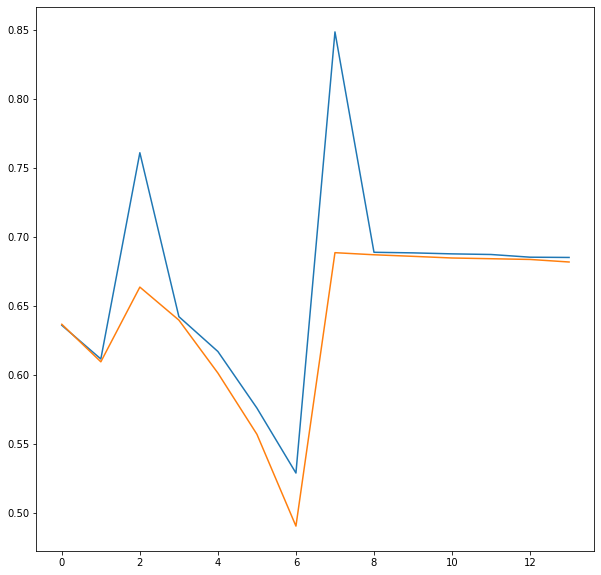

Epoch: 14, training loss: 0.68, validation loss: 0.68


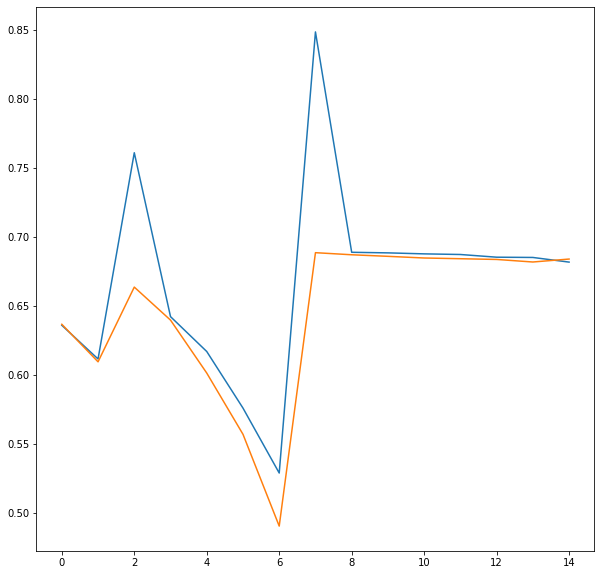

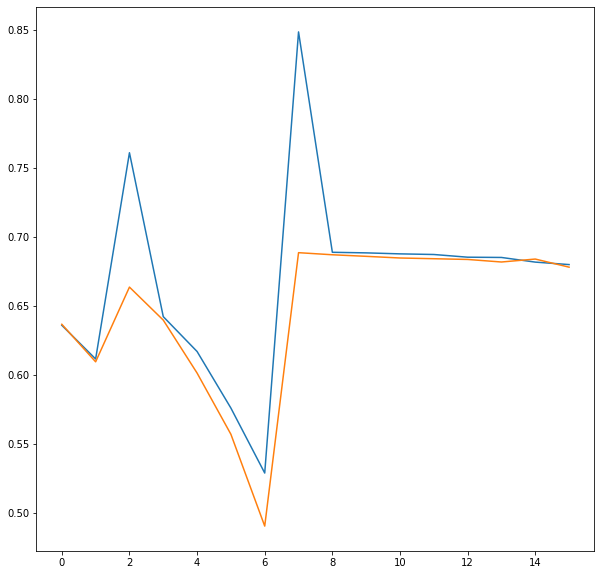

Epoch: 16, training loss: 0.68, validation loss: 0.68


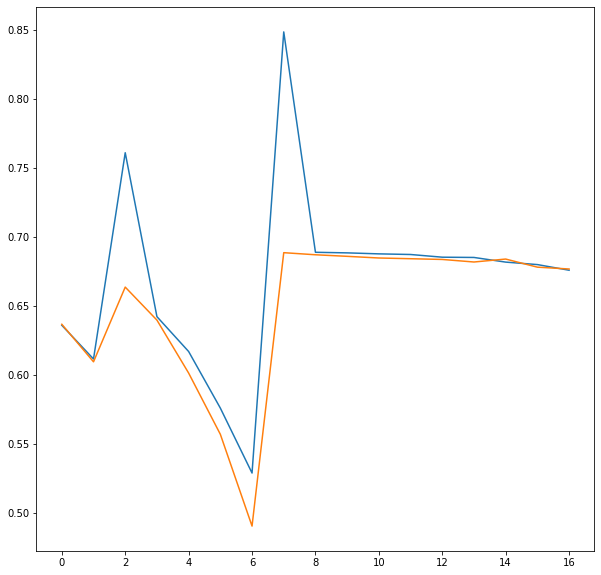

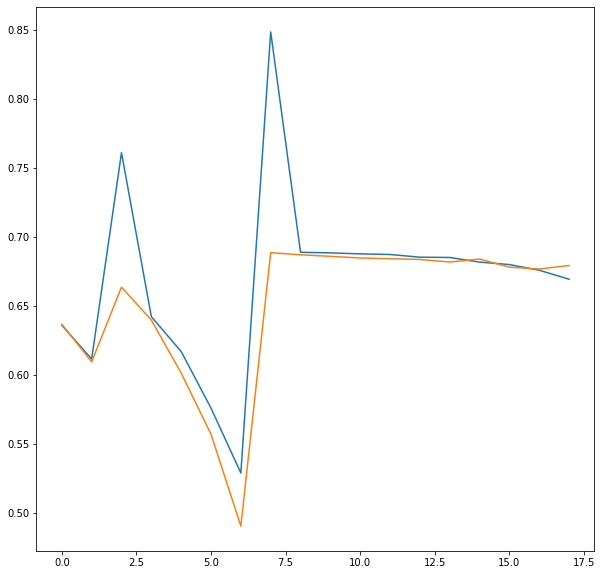

Epoch: 18, training loss: 0.67, validation loss: 0.67


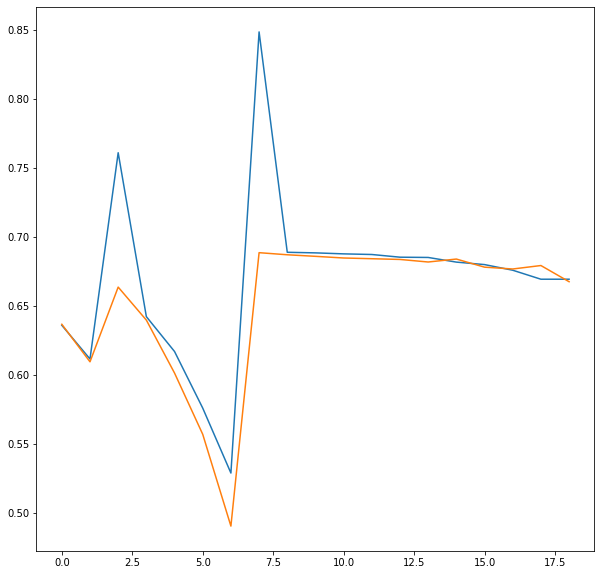

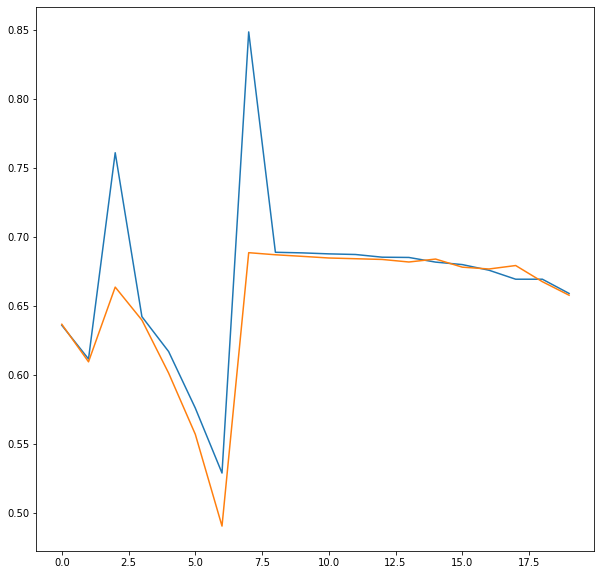

Epoch: 20, training loss: 0.65, validation loss: 0.65


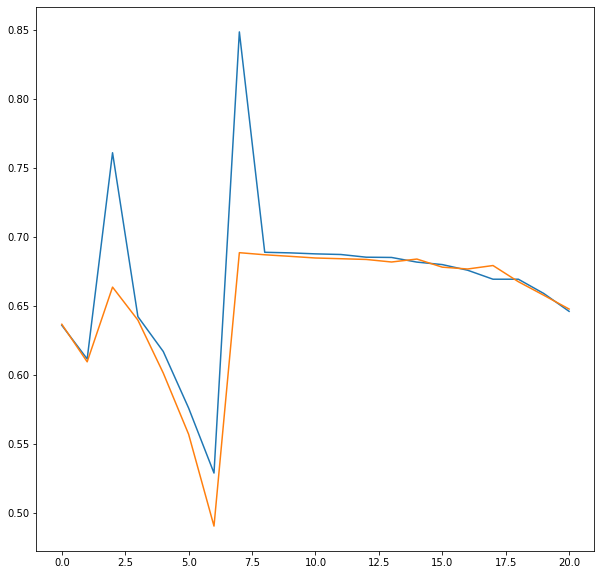

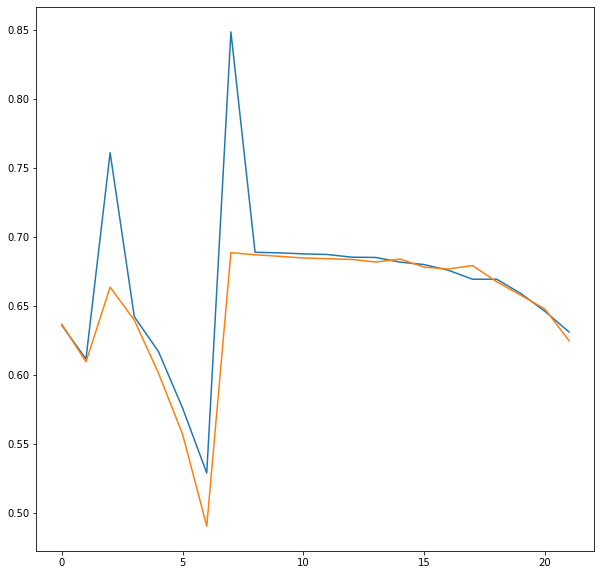

Epoch: 22, training loss: 0.74, validation loss: 0.69


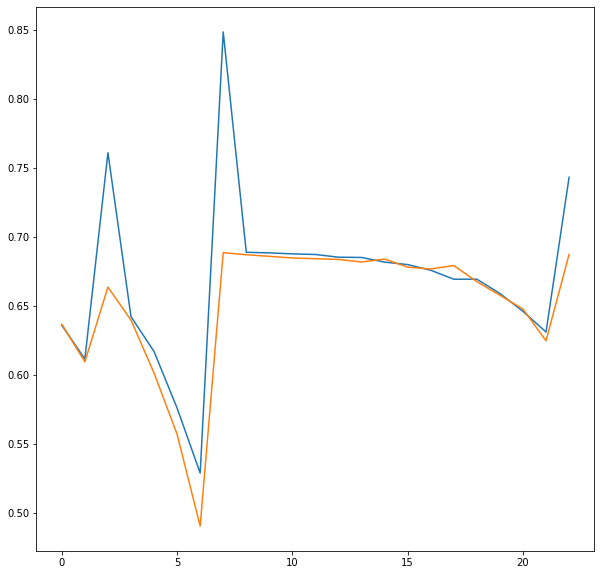

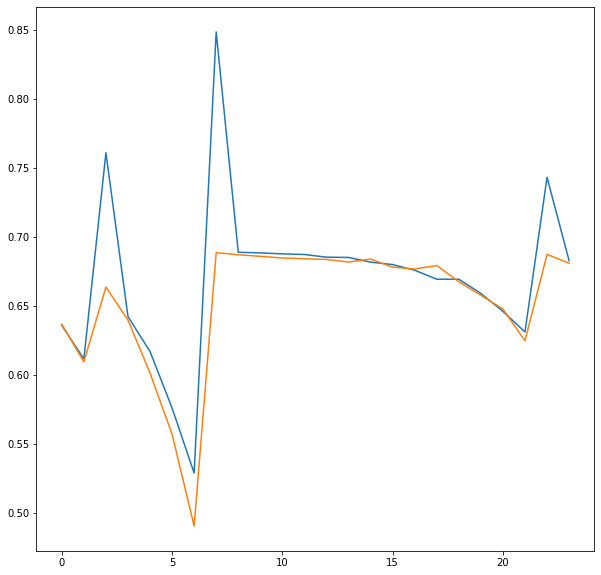

Epoch: 24, training loss: 0.67, validation loss: 0.67


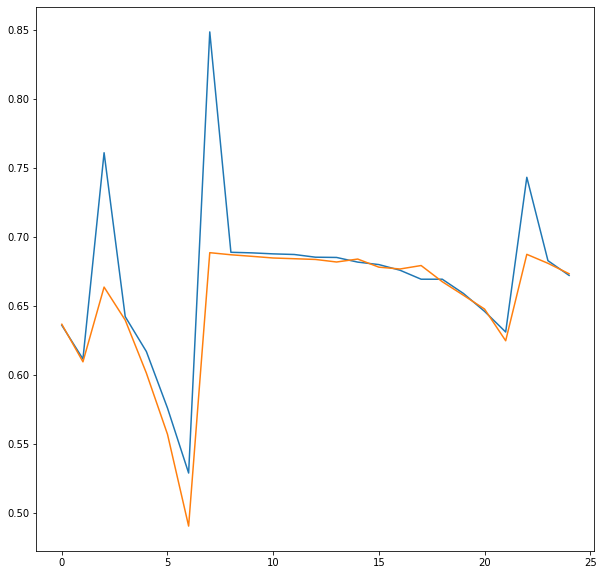

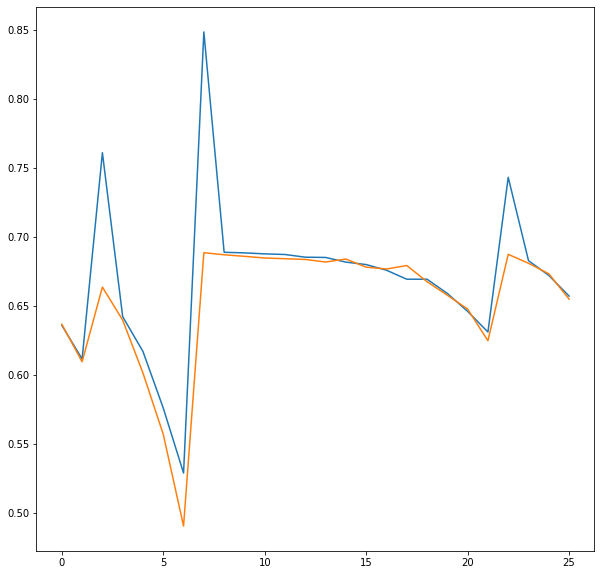

Epoch: 26, training loss: 0.62, validation loss: 0.63


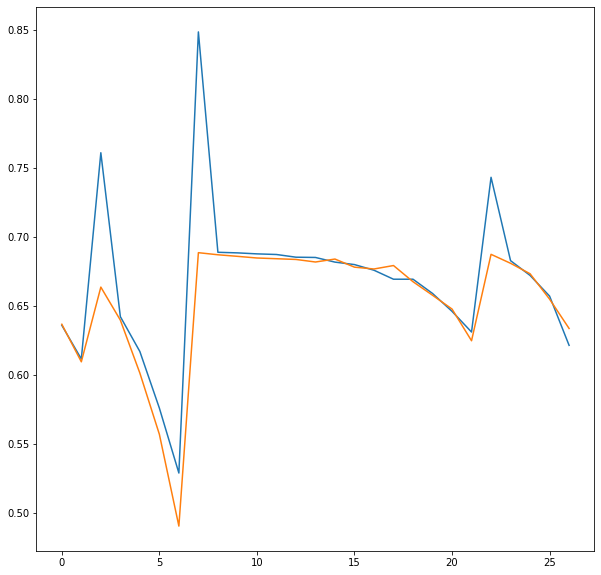

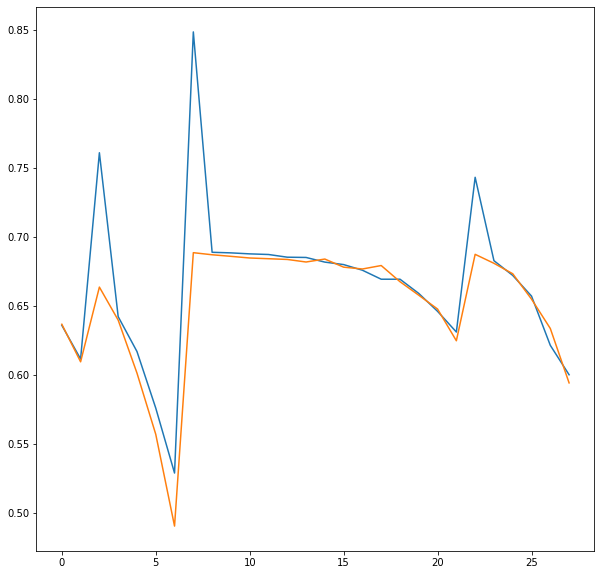

Epoch: 28, training loss: 0.56, validation loss: 0.58


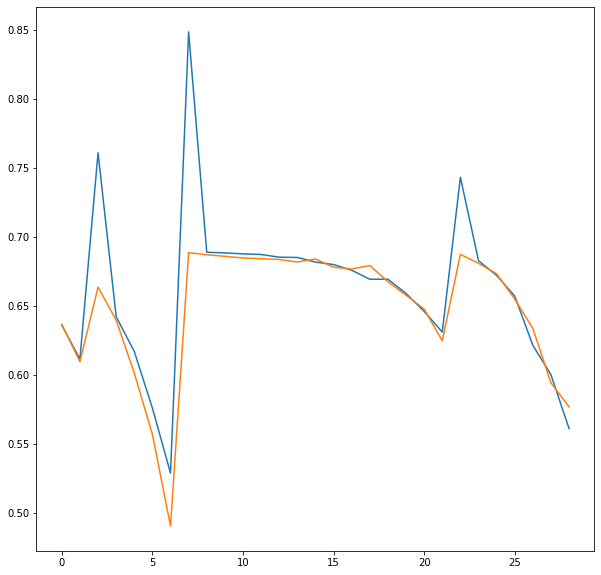

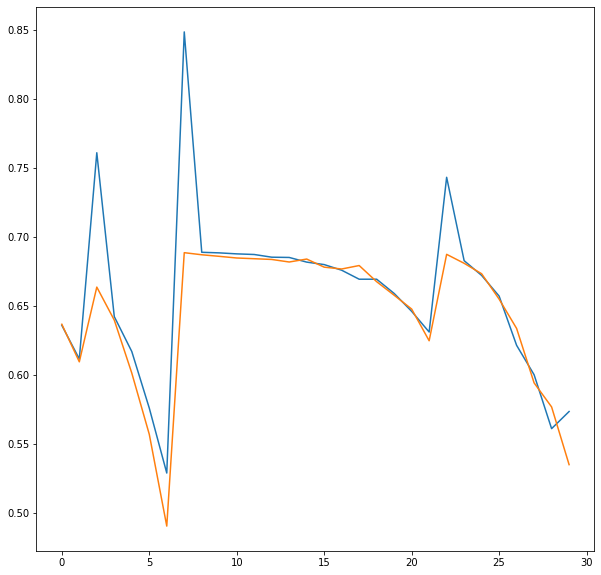

Epoch: 30, training loss: 0.52, validation loss: 0.45


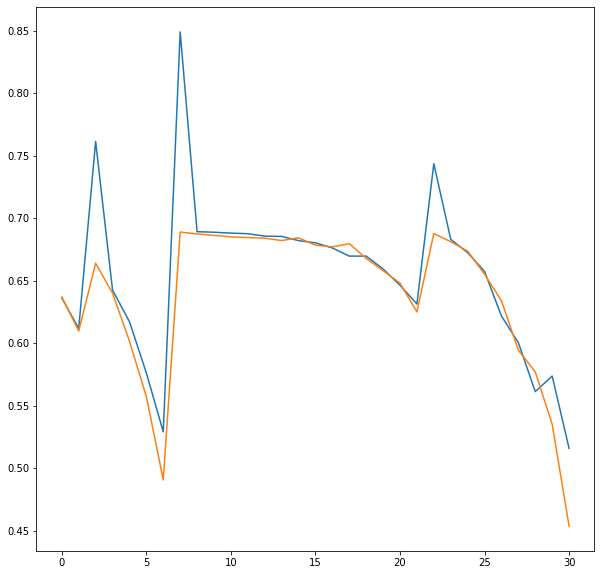

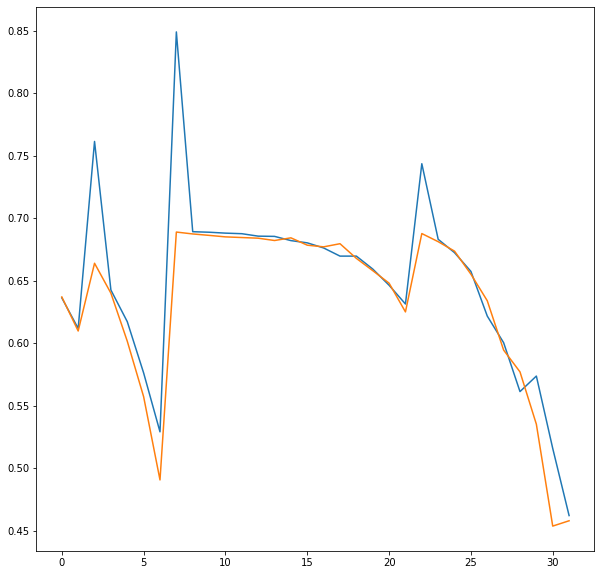

Epoch: 32, training loss: 0.45, validation loss: 0.53


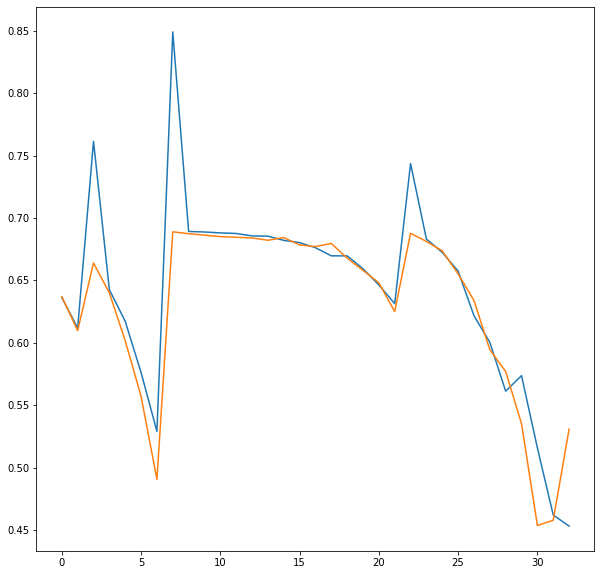

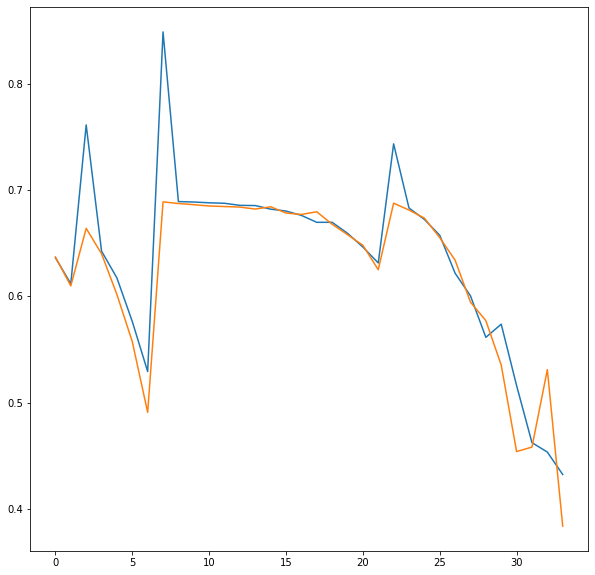

Epoch: 34, training loss: 0.45, validation loss: 0.39


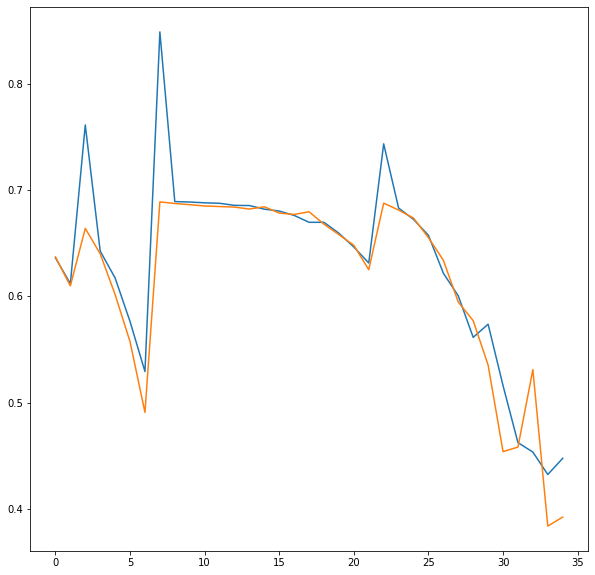

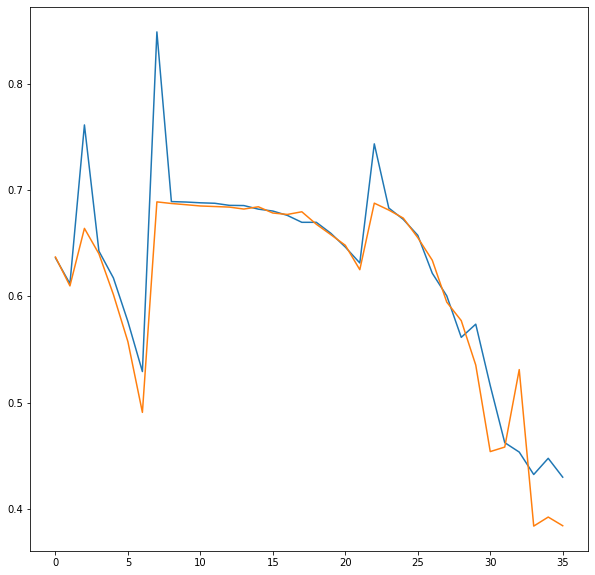

Epoch: 36, training loss: 0.59, validation loss: 0.55


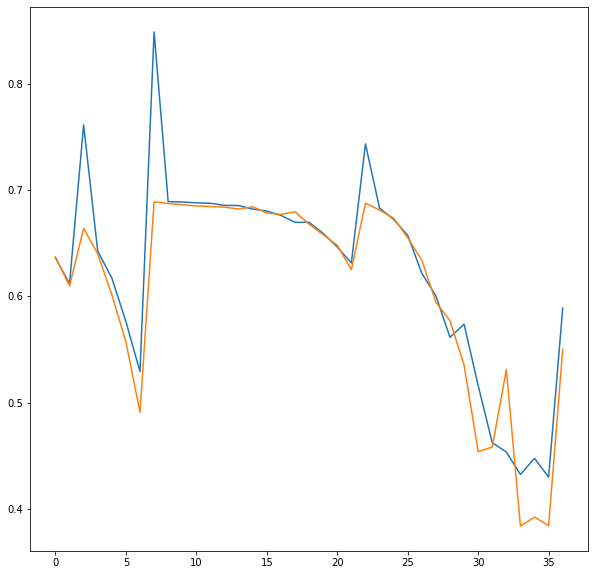

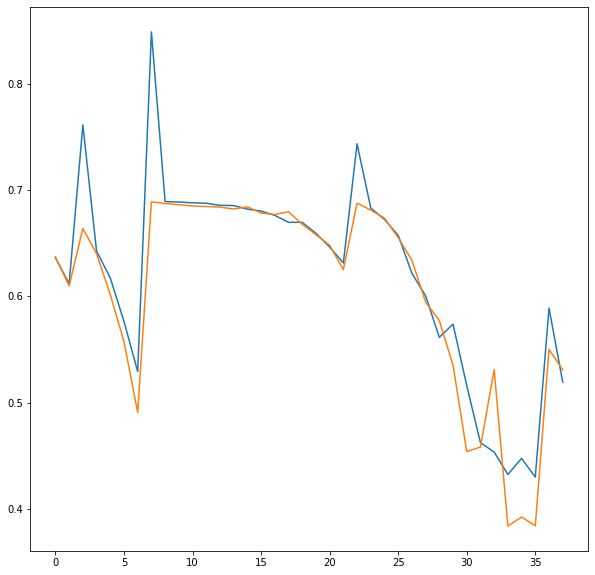

Epoch: 38, training loss: 0.45, validation loss: 0.43


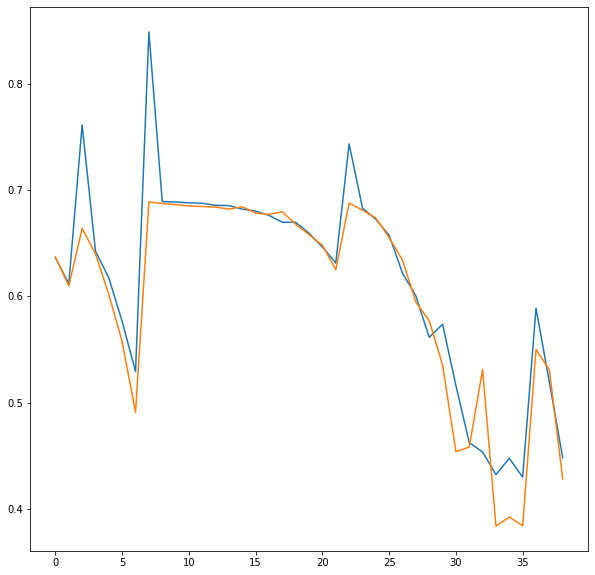

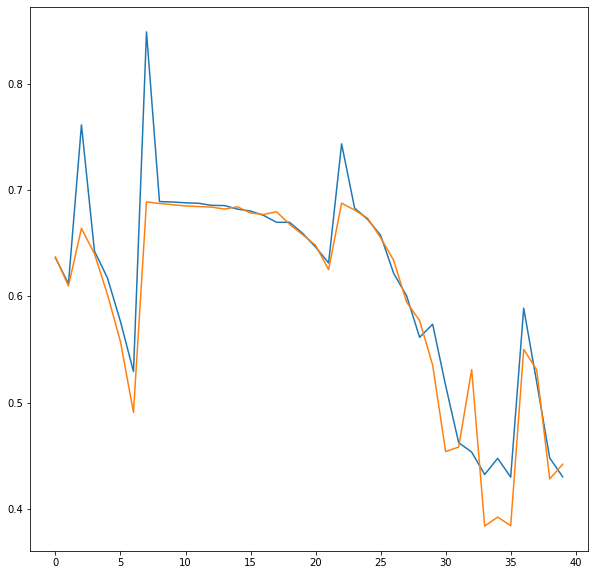

Epoch: 40, training loss: 0.40, validation loss: 0.41


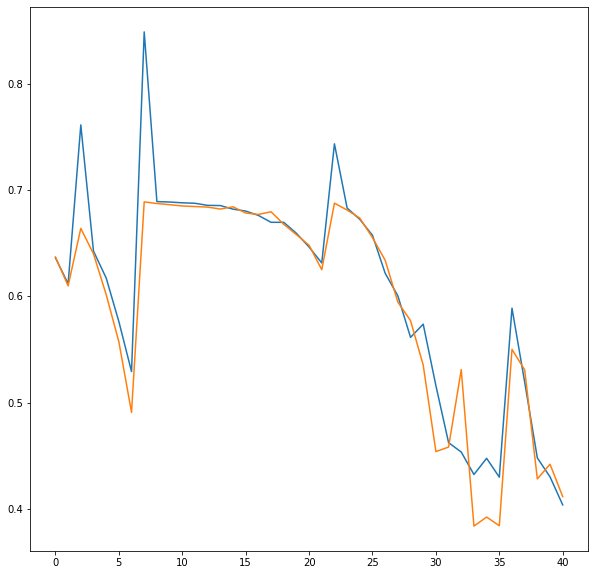

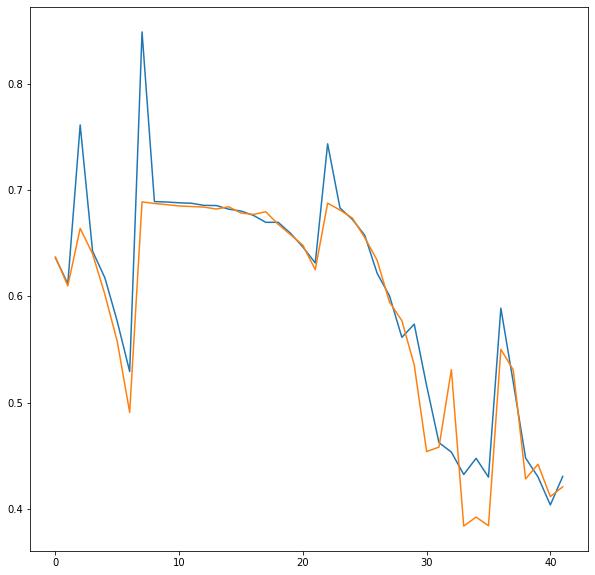

Epoch: 42, training loss: 0.37, validation loss: 0.43


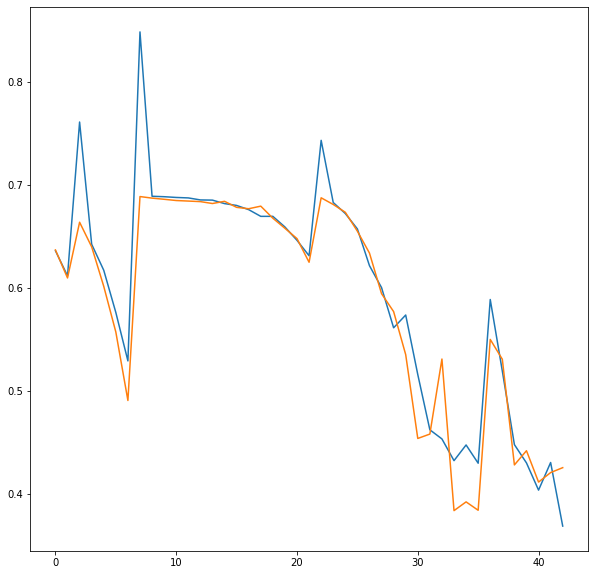

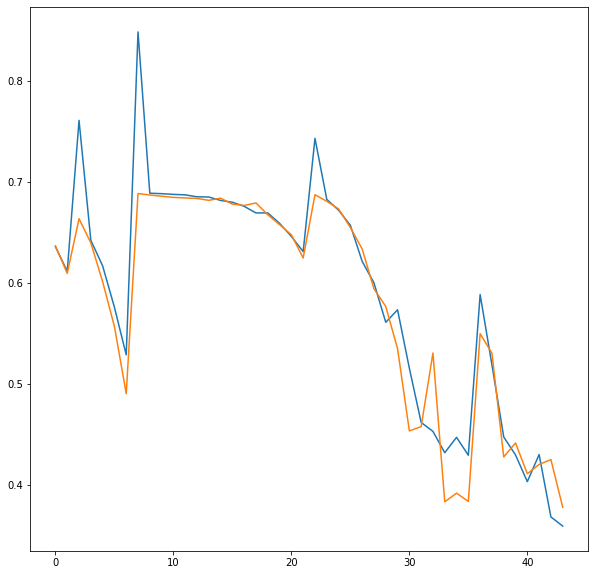

Epoch: 44, training loss: 0.34, validation loss: 0.38


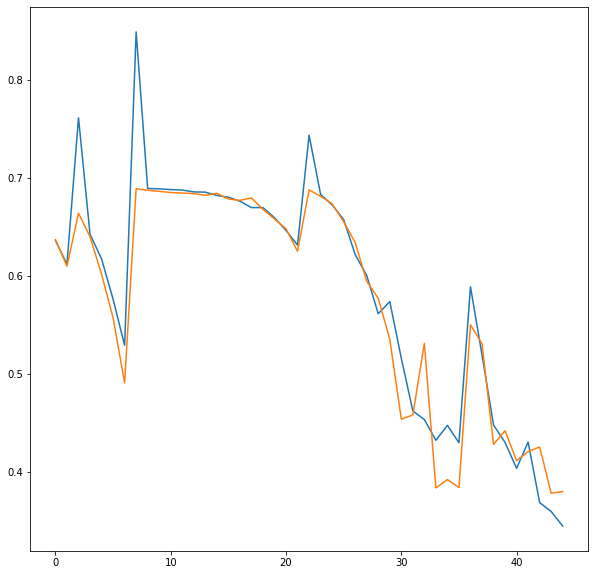

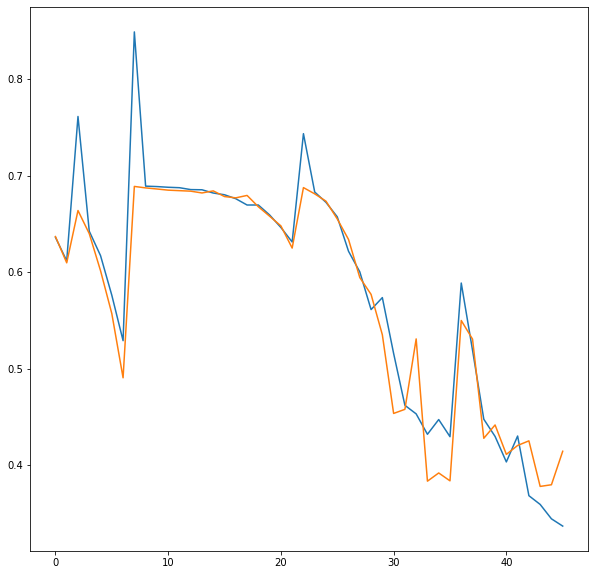

Epoch: 46, training loss: 0.31, validation loss: 0.31


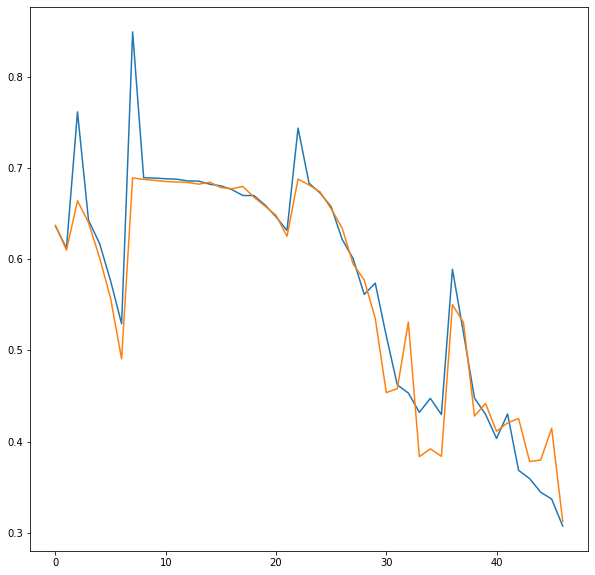

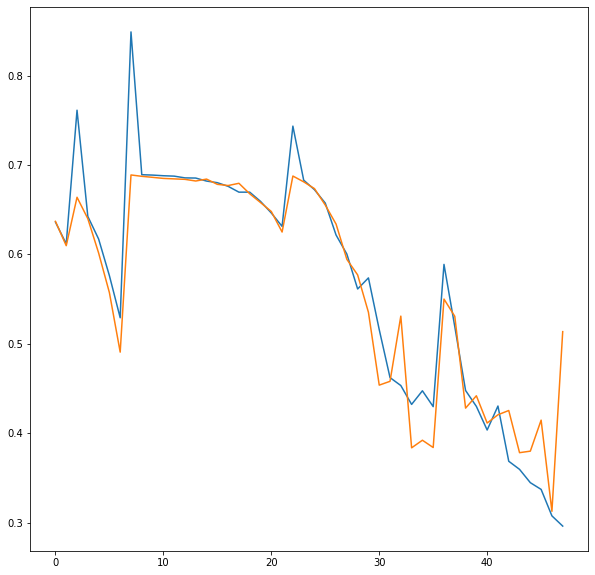

Epoch: 48, training loss: 0.30, validation loss: 0.33


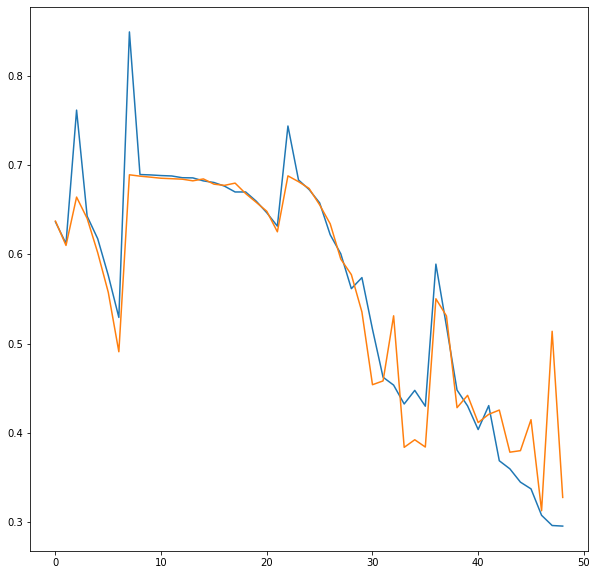

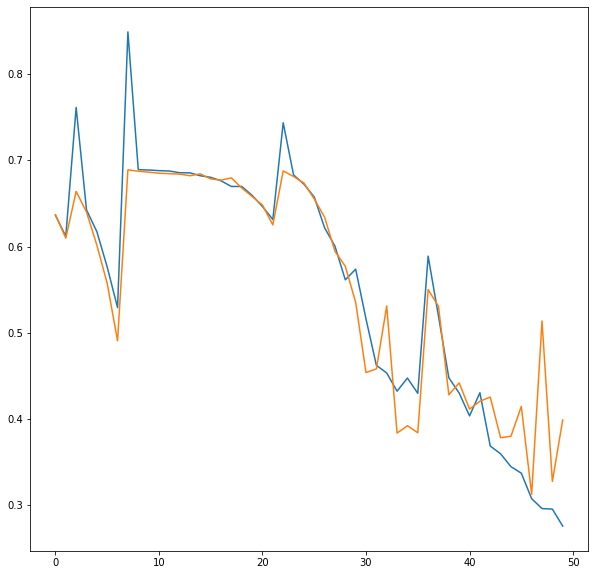

Epoch: 50, training loss: 0.69, validation loss: 0.51


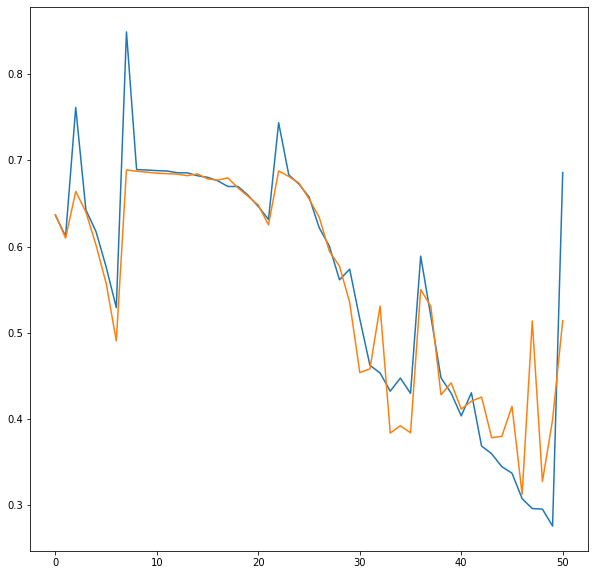

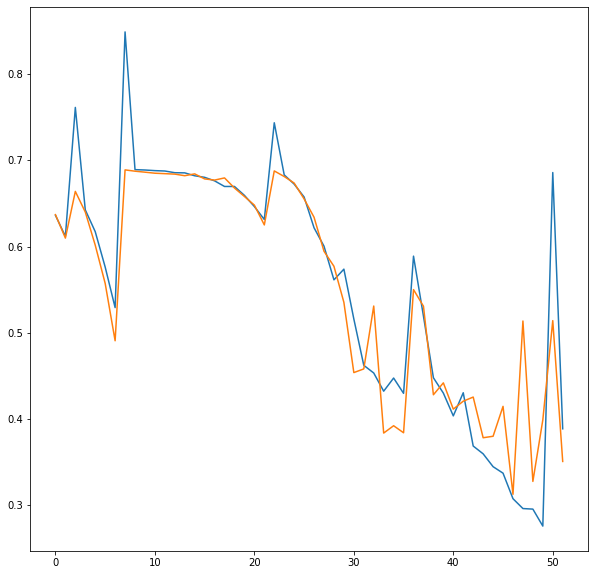

Epoch: 52, training loss: 0.31, validation loss: 0.34


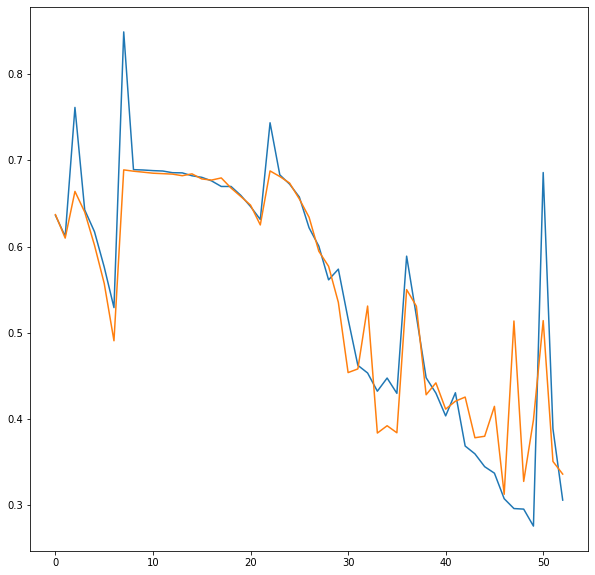

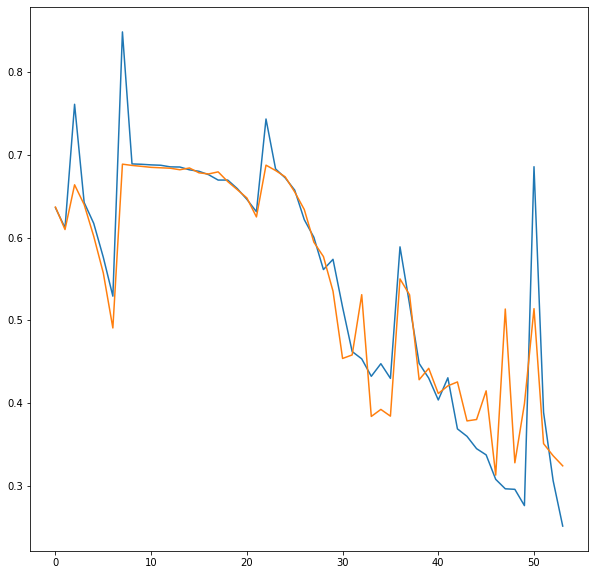

Epoch: 54, training loss: 0.31, validation loss: 0.32


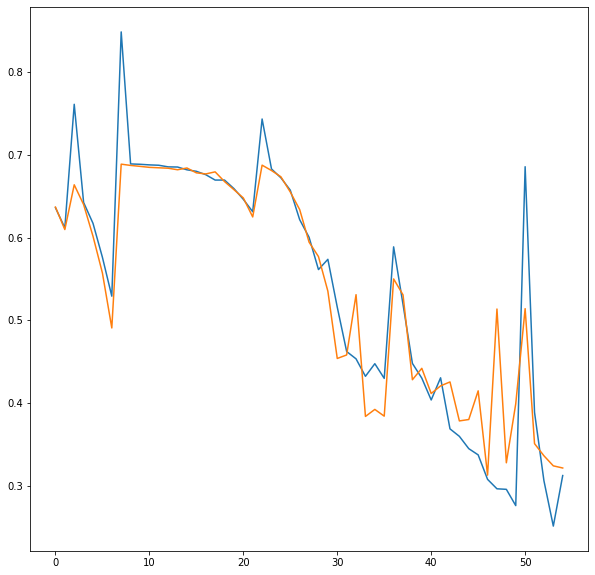

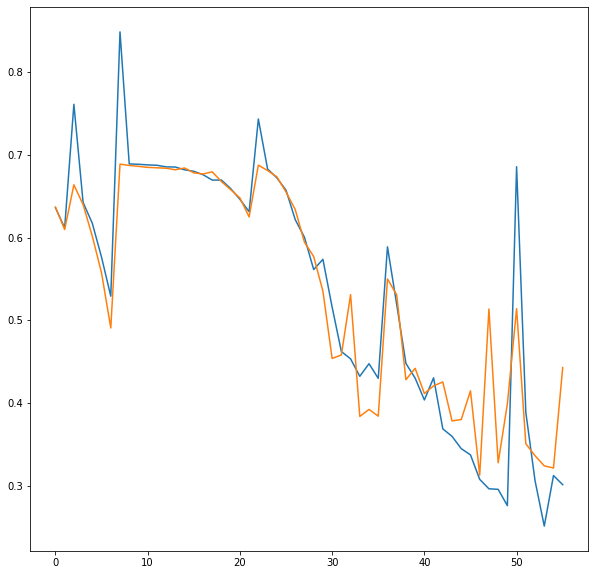

Epoch: 56, training loss: 0.22, validation loss: 0.49


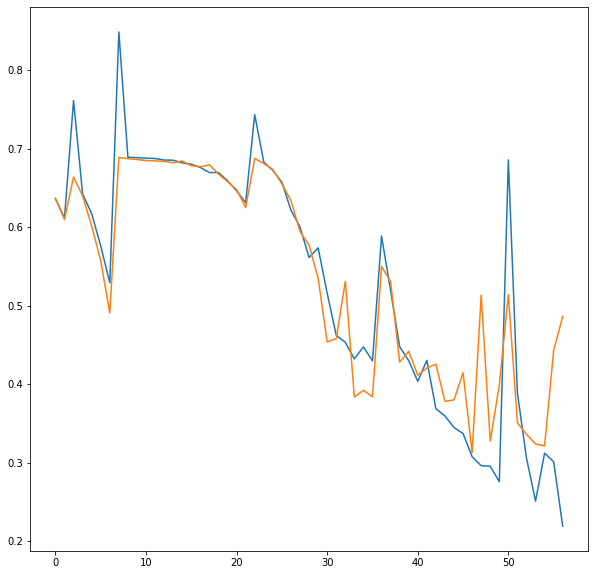

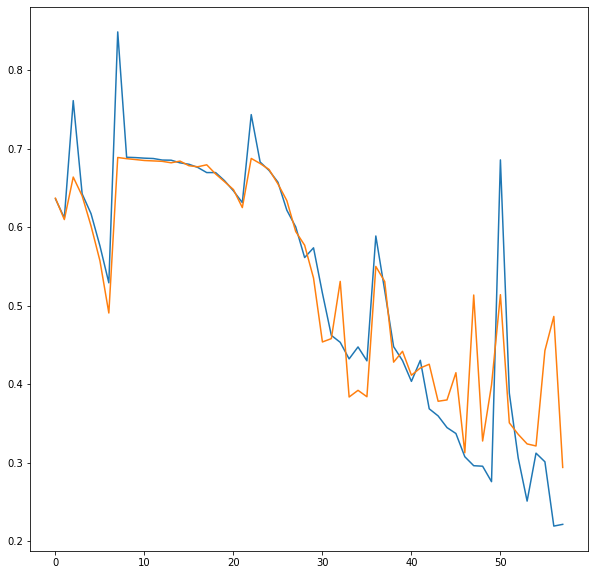

Epoch: 58, training loss: 0.18, validation loss: 0.43


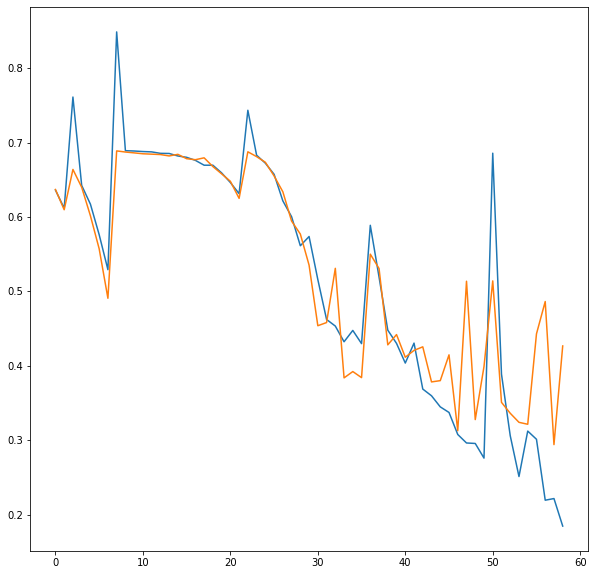

In [ ]:
train(net, criterion, optimizer, train_dataloader, val_dataloader, epochs = 100,plot=1)